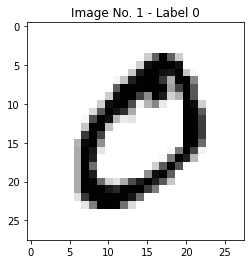

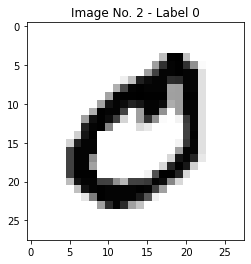

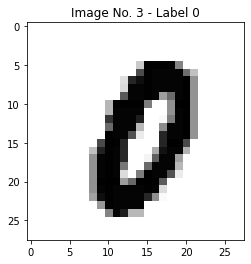

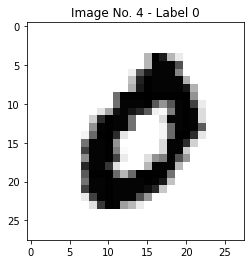

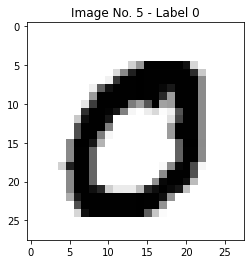

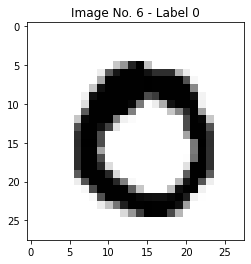

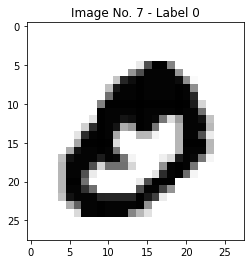

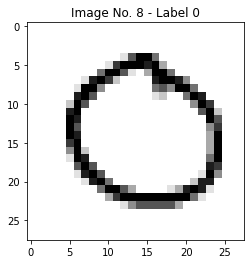

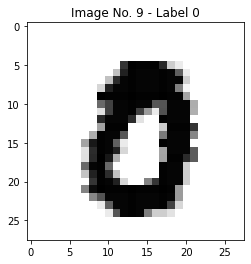

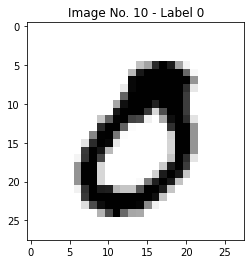

In [1]:
from scipy.io import loadmat
from scipy.ndimage import rotate
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import numpy as np
import random

#Load MNIST Data
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
mnist_label = mnist_label.astype(int)

#Display 1st 10 images with Labels
for i in range(10):
    image = mnist_data[i].reshape(28, 28)
    label = mnist_label[i]
    plt.imshow(image, cmap='gray_r', vmin=0, vmax=255)
    plt.title(f'Image No. {i + 1} - Label {label}')
    plt.show()

In [2]:
#MNIST Data is already flattened to 1D arrays

#Normalized all values to between 0 and 1
mnist_data=mnist_data/255

print(all(len(row) == 784 for row in mnist_data)) #check if every image has 784 values (28*28)
print(len(mnist_data) == len(mnist_label)) #check if each image has a label
print(np.isnan(mnist_data).any()) #check for NaNs
print(np.isnan(mnist_label).any()) #check for NaNs

#MNIST Data has no missing values

True
True
False
False


Label:0 Frequency:6903
Label:1 Frequency:7877
Label:2 Frequency:6990
Label:3 Frequency:7141
Label:4 Frequency:6824
Label:5 Frequency:6313
Label:6 Frequency:6876
Label:7 Frequency:7293
Label:8 Frequency:6825
Label:9 Frequency:6958


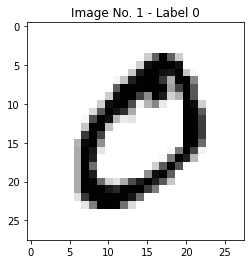

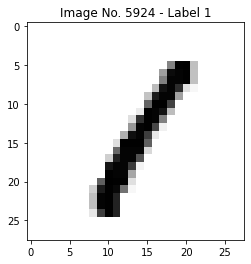

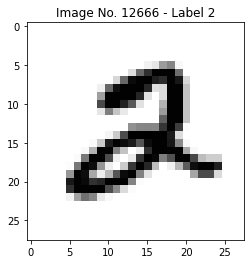

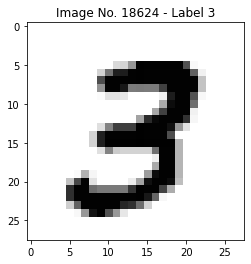

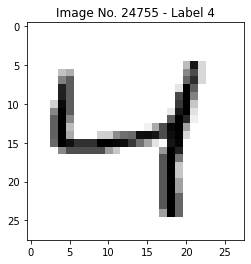

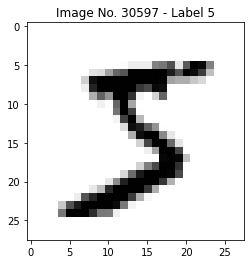

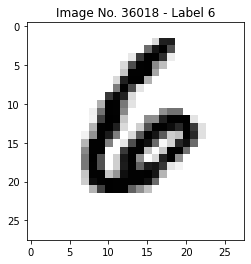

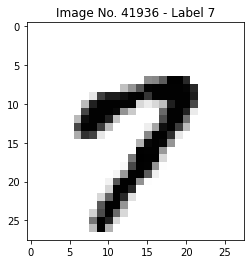

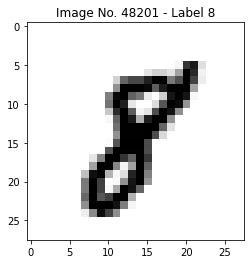

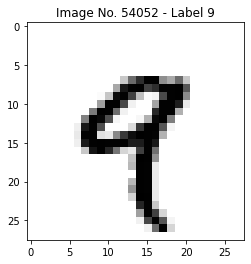

In [3]:
from collections import Counter

# Count the frequency of each unique value
counter = Counter(mnist_label)
# Separate keys (unique values) and values (frequencies)
x_values = list(counter.keys())
y_values = list(counter.values())
for i in range(10):
    print(f'Label:{x_values[i]} Frequency:{y_values[i]}')

#show 10 images from each class
for j in range(10):
    for i in range(70000):
        image = mnist_data[i].reshape(28, 28)  # Assuming mnist_data contains tuples of (image, label)
        label = mnist_label[i]
        if(label!=j):
            continue;
        plt.imshow(image, cmap='gray_r', vmin=0, vmax=1)
        plt.title(f'Image No. {i + 1} - Label {label}')
        plt.show()
        break;

In [4]:
#Scale image
def scale_image(image, scale_factor):
    # Get the height and width of the original image
    height, width = image.shape

    # Use NumPy's interpolation functions to scale the image
    scaled_image = np.zeros(image.shape, dtype=image.dtype)
    for i in range(height):
        for j in range(width):
            orig_i = int(i / scale_factor)
            orig_j = int(j / scale_factor)

            # Ensure the indices are within bounds
            orig_i = min(height - 1, orig_i)
            orig_j = min(width - 1, orig_j)

            # Assign the pixel value to the scaled image
            scaled_image[i, j] = image[orig_i, orig_j]

    return scaled_image


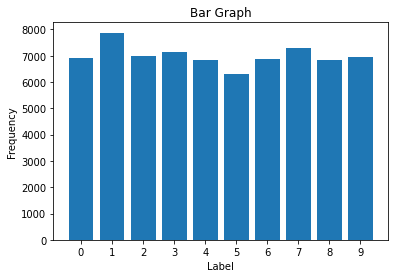

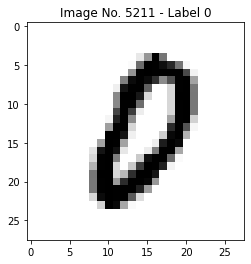

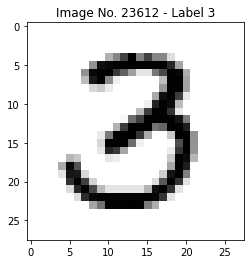

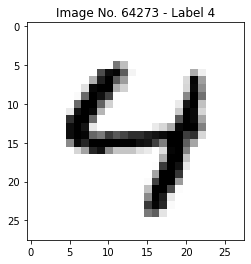

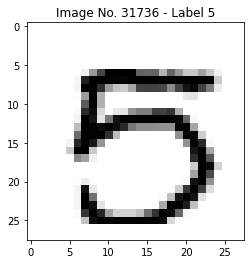

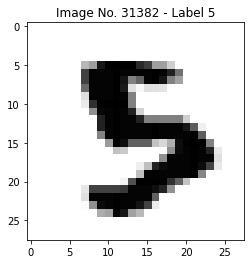

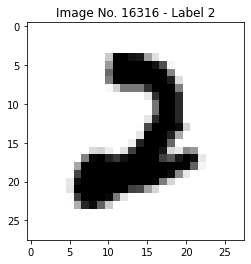

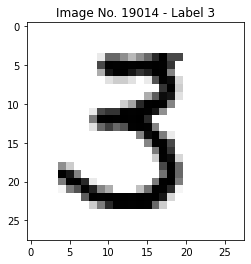

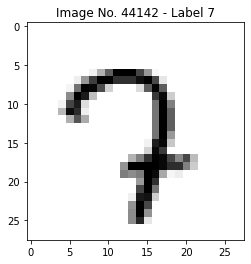

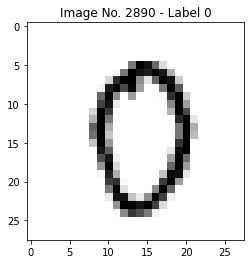

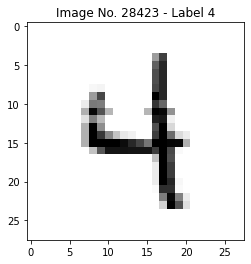

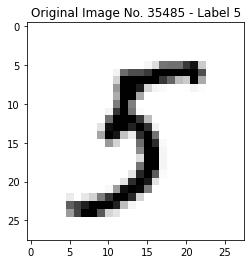

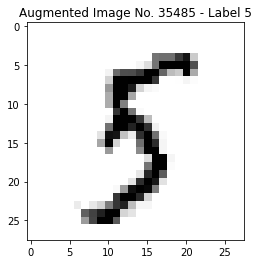

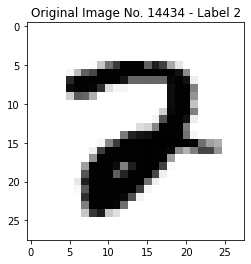

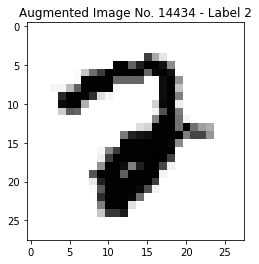

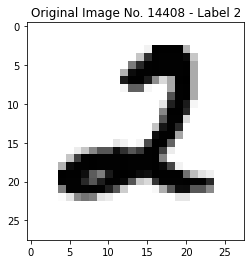

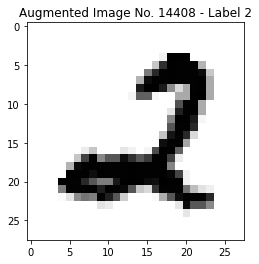

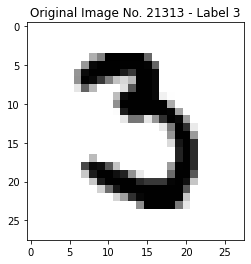

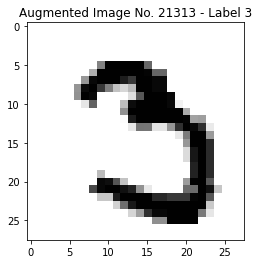

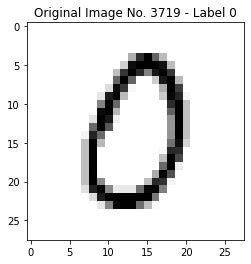

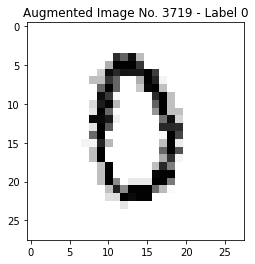

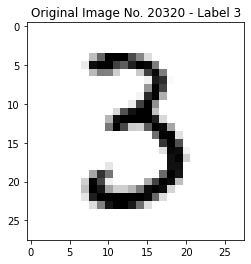

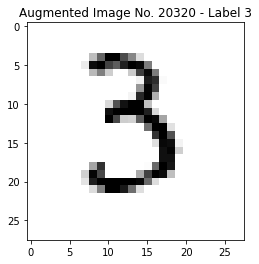

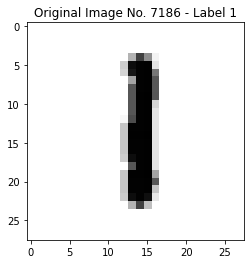

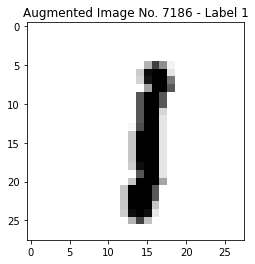

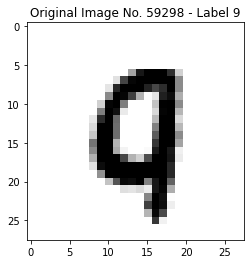

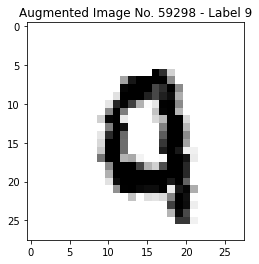

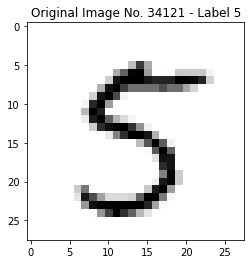

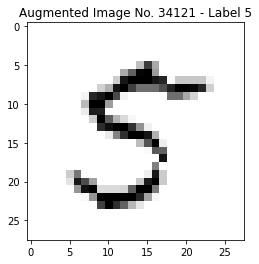

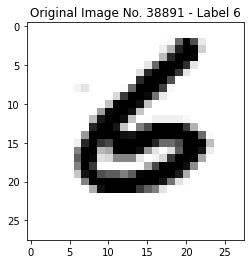

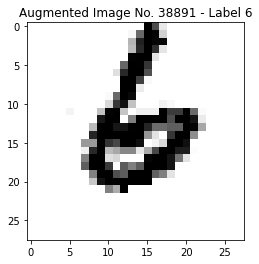

In [5]:
# Create a bar graph
plt.bar(x_values, y_values)
# Add labels and title
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Bar Graph')
plt.xticks(range(0, 10, 1))
# Display the graph
plt.show()

#Display 10 random images
for i in np.random.randint(0, 70000, size=10):
    image = mnist_data[i].reshape(28, 28)
    label = mnist_label[i]
    plt.imshow(image, cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'Image No. {i + 1} - Label {label}')
    plt.show()
    
#Image Augmentation is applied by rotating and scaling by small amounts 

for i in np.random.randint(0, 70000, size=10):
    image = mnist_data[i].reshape(28, 28)
    label = mnist_label[i]
    plt.imshow(image, cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'Original Image No. {i + 1} - Label {label}')
    plt.show()
    rot_im=rotate(image, random.randint(-20, 20), reshape=False, mode='constant', cval=0.0, order=0)
    zoom_im=scale_image(rot_im, random.uniform(0.9, 1.1))
    plt.imshow(zoom_im, cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'Augmented Image No. {i + 1} - Label {label}')
    plt.show()
    mnist_data = np.vstack([mnist_data, zoom_im.reshape(1,784)])
    mnist_label=np.append(mnist_label,mnist_label[i])


In [6]:
#Split into train and test

# Get the indices for the train subarray
indices1 = np.random.choice(mnist_data.shape[0], size=60000, replace=False)
  
# Get the indices for the test subarray
indices2 = np.setdiff1d(np.arange(mnist_data.shape[0]), indices1)
   
# Create the two subarrays
mnist_data_train = mnist_data[indices1]
mnist_data_train = mnist_data_train.reshape((len(indices1),28,28))
mnist_data_train = mnist_data_train.astype(np.float32)
mnist_label_train = mnist_label[indices1]

mnist_data_test = mnist_data[indices2]
mnist_data_test = mnist_data_test.reshape((len(indices2),28,28))
mnist_data_test = mnist_data_test.astype(np.float32)
mnist_label_test = mnist_label[indices2]

In [7]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy.ndarray): Array of images.
            labels (numpy.ndarray): Array of corresponding labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.from_numpy(image.reshape(1,28,28))
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return (image, label)

# Example usage:
# Assuming you have 'images_array' and 'labels_array' as your image and label arrays
# You can create an instance of your CustomDataset like this:
custom_dataset = CustomDataset(images=mnist_data_train, labels=mnist_label_train)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cpu")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, num_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted input size based on 28x28 images
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Download and prepare MNIST dataset
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_mnist = CustomDataset(images=mnist_data_train, labels=mnist_label_train)
test_dataset_mnist = CustomDataset(images=mnist_data_test, labels=mnist_label_test)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model_mnist = SimpleCNN(num_classes=10, num_channels=1).to(device)
criterion_mnist = nn.CrossEntropyLoss()
optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=0.001)

# Training loop for MNIST
num_epochs = 5

for epoch in range(num_epochs):
    model_mnist.train()
    running_loss = 0.0
    for images, labels in train_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        optimizer_mnist.zero_grad()
        outputs = model_mnist(images)
        loss = criterion_mnist(outputs, labels)
        loss.backward()
        optimizer_mnist.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader_mnist)}")




Epoch 1/5, Loss: 0.18211836929766656
Epoch 2/5, Loss: 0.05383899844443199
Epoch 3/5, Loss: 0.03657197011788604
Epoch 4/5, Loss: 0.02740862006811164
Epoch 5/5, Loss: 0.019807208122020074


Accuracy on the test set for MNIST: 98.89%


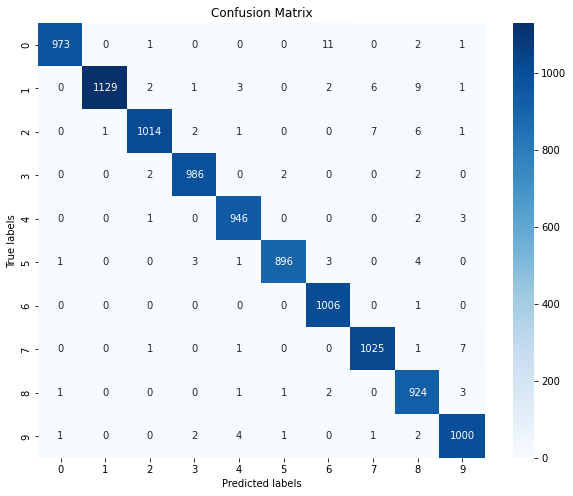

In [23]:
model_mnist.eval()
all_labels = []
all_predictions = []
misclassified_images = []

with torch.no_grad():
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mnist(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = np.sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
print(f"Accuracy on the test set for MNIST: {100 * accuracy:.2f}%")

# Create confusion matrix
conf_mat = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()